# Analysis of Banks' Customer Reviews on [banki.ru](https://www.banki.ru)
Featured products
* *debitcards*
* *creditcards*
* *hypothec* - mortgage loans
* *credits* - consumer credits
* *deposits*

For complains/thanks classification webpage's own division is used
* "о хорошем" (good) - ratings 4-5
* "о плохом" (bad) - ratings 1-2

In [2]:
import time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
# import nltk
# nltk.download("stopwords")

from datetime import date

from bs4 import BeautifulSoup

from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')

In [3]:
def parse_product(bank='rosbank',
                  product='debitcards',
                  rated=True) -> pd.DataFrame:
    """
    Returns all customer reviews from banki.ru for the given bank and product.
    
    
    Parameters
    ----------
    bank : str, default: 'rosbank'
        Bank name from banki.ru. Look it up in the address bar while browsing.

    product : str, default: 'debitcards'
        Name of the product to parse reviews of. Again, must be from
        banki.ru.

    rated : bool, default: True
        Whether to accept only rated or unrated reviews.


    Returns
    -------
    pandas.DataFrame
        DataFrame with reviews according to the parameters.
    """
    # initializing final lists and some parameters for the query
    page = 1
    rated = 'rate[]=1&rate[]=2&rate[]=3&rate[]=4&rate[]=5&' if rated else ''
    Review = []
    if rated:
        Rating = []

    # starting to parse
    while True:
        url = f'https://www.banki.ru/services/responses/bank/{bank}/product/{product}/?{rated}page={page}&isMobile=0'
        req = requests.get(url)
        
        # OK response
        if req.status_code == 200:
            tree = BeautifulSoup(req.content,
                                 'html.parser')
            headers = tree.find_all('a',
                                    'header-h3')
            bodies = tree.find_all('div',
                                   'responses__item__message markup-inside-small markup-inside-small--bullet')

            # prettifying reviews
            reviews = [header.text + '\n' + body.get_text('\n').strip().replace('\xa0', ' ')
                       for header, body in zip(headers, bodies)]
            if rated:
                ratings = tree.find_all('span',
                                        {'data-test': 'responses-rating-grade'})
                Rating.extend([int(rating.text.strip()) for rating in ratings])
            Review.extend(reviews)

            # moving on to the next webpage and
            # sleeping to avoid the occasional ban (uses more time)
            # also using print just to keep track of the progress
            print(f'bank: {bank}, product: {product}, page: {page}')
            page += 1
            time.sleep(2)

        # request throws 404 when we run out of pages
        elif rated:
            return pd.DataFrame({'Review': Review,
                                 'Rating': Rating,
                                 'Product': product,
                                 'Bank': bank})
        else:
            return pd.DataFrame({'Review': Review,
                                 'Product': product,
                                 'Bank': bank})

In [4]:
# the bank name and categories of products to extract
bank = 'rosbank'
products = ['debitcards',
            'creditcards',
            'hypothec',
            'credits',
            'deposits']

In [4]:
# parsing, using sleep to avoid the occasional ban
df = []
for product in products:
    try:
        df.append(parse_product(bank=bank, product=product))
#         time.sleep(15)
    except:
        time.sleep(15)
        df.append(parse_product(bank=bank, product=product))
        time.sleep(5)
# df = pd.concat((parse_product(bank=bank, product=product) for product in products),
#                ignore_index=True)
df = pd.concat(df, ignore_index=True, copy=False)

bank: rosbank, product: debitcards, page: 1
bank: rosbank, product: debitcards, page: 2
bank: rosbank, product: debitcards, page: 3
bank: rosbank, product: debitcards, page: 4
bank: rosbank, product: debitcards, page: 5
bank: rosbank, product: debitcards, page: 6
bank: rosbank, product: debitcards, page: 7
bank: rosbank, product: debitcards, page: 8
bank: rosbank, product: debitcards, page: 9
bank: rosbank, product: debitcards, page: 10
bank: rosbank, product: debitcards, page: 11
bank: rosbank, product: debitcards, page: 12
bank: rosbank, product: debitcards, page: 13
bank: rosbank, product: debitcards, page: 14
bank: rosbank, product: debitcards, page: 15
bank: rosbank, product: debitcards, page: 16
bank: rosbank, product: debitcards, page: 17
bank: rosbank, product: debitcards, page: 18
bank: rosbank, product: debitcards, page: 19
bank: rosbank, product: debitcards, page: 20
bank: rosbank, product: debitcards, page: 21
bank: rosbank, product: debitcards, page: 22
bank: rosbank, prod

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [21]:
# creating target column for complains/thanks
df['IsGratitude'] = (df.Rating > 3).astype(int)

# creating target column for product classification
encoder = LabelEncoder()
encoder.fit(df.Product)
df['Product_int'] = encoder.transform(df.Product)

# product -> class
products_to_int = sorted(zip(products, encoder.transform(products)),
                         key=lambda x: x[-1])

In [178]:
df

,Review,Rating,Product,Bank,IsGratitude,Product_int
0,Обращение к руководству Росбанка\nЯ ОБРАЩАЮСЬ...,5,debitcards,rosbank,1,2
1,воровство\nБанк начал воровать/ списывать еж...,1,debitcards,rosbank,0,2
2,Отказываются переводить на бесплатный тариф ди...,1,debitcards,rosbank,0,2
3,Некомпетентность или халатность. Пропали деньг...,1,debitcards,rosbank,0,2
4,Росбанк - террорист!\nПо своему усмотрению и б...,1,debitcards,rosbank,0,2
...,...,...,...,...,...,...
6115,"Пока не знаю точно, честно ли они работают\nЯ ...",3,deposits,rosbank,0,3
6116,Нарушение порядка кассовых операций\nПриехал к...,1,deposits,rosbank,0,3
6117,Неприятное впечатление\nХотелось бы оставить о...,1,deposits,rosbank,0,3
6118,Каждый раз - что-нибудь новое\nУ меня есть вкп...,1,deposits,rosbank,0,3


### Optional: saving the gathered data

In [13]:
df.to_csv(f'{bank}_reviews_{date.today()}.csv', index=False)

### Preprocessing

In [5]:
df = pd.read_csv('rosbank_reviews_2021-01-09.csv', index_col=0)
df

,Review,Rating,Product,IsGratitude,Product_int
0,Вранье зашкаливает\n06.01.21 посредством СБП п...,1,debitcards,0,2
1,Возмущен обслуживанием\n15 октября обратился в...,1,debitcards,0,2
2,"Ипотека продавцы\nДобрый вечер, хотел бы подел...",1,debitcards,0,2
3,11 дней с заблокированным счетом по вине банка...,1,debitcards,0,2
4,Сервис - 0! Не могу закрыть счета уже более 2 ...,1,debitcards,0,2
...,...,...,...,...,...
6094,"Пока не знаю точно, честно ли они работают\nЯ ...",3,deposits,0,3
6095,Нарушение порядка кассовых операций\nПриехал к...,1,deposits,0,3
6096,Неприятное впечатление\nХотелось бы оставить о...,1,deposits,0,3
6097,Каждый раз - что-нибудь новое\nУ меня есть вкп...,1,deposits,0,3


In [6]:
# removing punctuation, digits (mainly dates) and whitespace chars
df['Review'] = df.Review.str.replace(r'[\W\s\d]+', ' ')
df

,Review,Rating,Product,IsGratitude,Product_int
0,Вранье зашкаливает посредством СБП перевел т р...,1,debitcards,0,2
1,Возмущен обслуживанием октября обратился в Рос...,1,debitcards,0,2
2,Ипотека продавцы Добрый вечер хотел бы поделит...,1,debitcards,0,2
3,дней с заблокированным счетом по вине банка З...,1,debitcards,0,2
4,Сервис Не могу закрыть счета уже более месяцев...,1,debitcards,0,2
...,...,...,...,...,...
6094,Пока не знаю точно честно ли они работают Я вы...,3,deposits,0,3
6095,Нарушение порядка кассовых операций Приехал к ...,1,deposits,0,3
6096,Неприятное впечатление Хотелось бы оставить от...,1,deposits,0,3
6097,Каждый раз что нибудь новое У меня есть вкпады...,1,deposits,0,3


## Binary classification into complains/thanks
**This is true for Rosbank data and has not been tested on others!**

Classes are unbalanced, but not too much, so I chose accuracy as the primary metric.

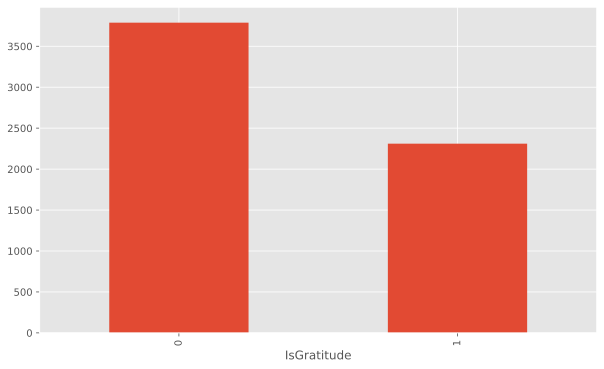

In [7]:
# observing classes
fig = plt.figure(figsize=(10, 6))
df.groupby('IsGratitude').Review.count().plot.bar(ylim=0)
plt.show()

In [8]:
# splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df[df.Rating != 3].Review.values,
                                                    df[df.Rating != 3].IsGratitude.values,
                                                    test_size=0.2,
                                                    random_state=173)

# preprocessing
vectorizer = TfidfVectorizer(max_df=0.95,
                             ngram_range=(1, 2),
                             max_features=200000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [9]:
# training the model
lsvc = LinearSVC(C=2,
                 loss='hinge',
                 random_state=173)
lsvc.fit(X_train_vect, y_train)

# observing test score
lsvc.score(X_test_vect, y_test)

0.988135593220339

Alternative models which perform a little worse

In [10]:
# training the model
svc = SVC(C=1.9,
          kernel='sigmoid',
          random_state=173)
svc.fit(X_train_vect, y_train)

# observing test score
svc.score(X_test_vect, y_test)

0.9847457627118644

In [11]:
# training the model
cnb = ComplementNB(alpha=0.1)
cnb.fit(X_train_vect, y_train)

# observing test score
cnb.score(X_test_vect, y_test)

0.976271186440678

## Multinomial classification into different products

Classes are really unbalanced, later we look at the classification report.

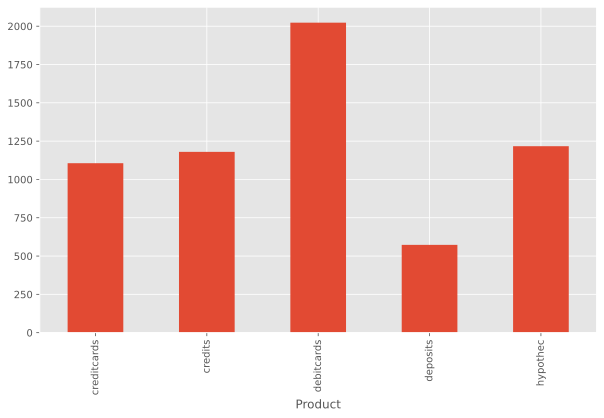

In [12]:
# observing classes
fig = plt.figure(figsize=(10, 6))
df.groupby('Product').Review.count().plot.bar(ylim=0)
plt.show()

In [13]:
# hoping that stop words will improve the quality
stop_words = stopwords.words("russian")

In [14]:
# splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df.Review.values,
                                                    df.Product_int.values,
                                                    test_size=0.2,
                                                    random_state=173)

# preprocessing
# NOTE: for previous classification these parameters do not really change accuracy
vectorizer = TfidfVectorizer(min_df=5,
                             max_df=0.95,
                             max_features=1000,
                             ngram_range=(1, 2),
                             stop_words=stop_words,
                             sublinear_tf=True)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [19]:
# training the model and observing reports
lsvc = LinearSVC(C=0.5,
                 loss='hinge',
                 random_state=173)
lsvc.fit(X_train_vect, y_train)
print(
    'training report:',
    classification_report(y_train,
                          lsvc.predict(X_train_vect),
                          target_names=df.Product.unique()),
    '=' * 80,
    'test report:',
    classification_report(y_test,
                          lsvc.predict(X_test_vect),
                          target_names=df.Product.unique()),
    sep='\n'
)

training report:
              precision    recall  f1-score   support

  debitcards       0.75      0.53      0.62       870
 creditcards       0.75      0.79      0.77       947
    hypothec       0.72      0.87      0.79      1626
     credits       0.77      0.50      0.61       459
    deposits       0.87      0.90      0.89       977

    accuracy                           0.76      4879
   macro avg       0.77      0.72      0.73      4879
weighted avg       0.77      0.76      0.76      4879

test report:
              precision    recall  f1-score   support

  debitcards       0.71      0.48      0.57       236
 creditcards       0.64      0.67      0.65       233
    hypothec       0.62      0.77      0.69       397
     credits       0.63      0.38      0.47       114
    deposits       0.77      0.81      0.79       240

    accuracy                           0.67      1220
   macro avg       0.67      0.62      0.64      1220
weighted avg       0.67      0.67      0.66    

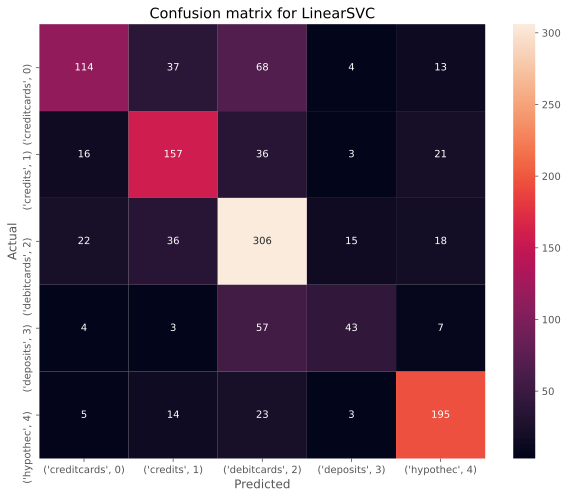

In [22]:
# looking for mistakes in classification
fig = plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, lsvc.predict(X_test_vect)),
            annot=True,
            fmt='d',
            xticklabels=products_to_int,
            yticklabels=products_to_int)
plt.title('Confusion matrix for LinearSVC')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()